In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import time
from tqdm import tqdm


In [2]:

# Load the dataset from a CSV file.
df = pd.read_csv("data/processed/EEG-data.csv")


# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Helper Functions
def print_color(text: str, color: str) -> None:
    """
    Prints text in specified ANSI color for better readability.
    
    Args:
        text (str): Text to be printed
        color (str): Color name ('red', 'green', 'yellow', 'blue', 'magenta')
    """
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors.get(color, '')}{text}\033[0m")


In [4]:

def plot_eeg_channels(data: np.ndarray, title: str = "EEG Signals", 
                     sample_idx: int = 0, channels: int = 8) -> None:
    """
    Plot EEG channels from a window of data.
    
    Args:
        data (np.ndarray): EEG data array with shape (windows, time_steps, channels)
        title (str): Title for the plot
        sample_idx (int): Index of the window to plot
        channels (int): Number of EEG channels
    """
    plt.figure(figsize=(12, 16))
    window_data = data[sample_idx]
    for i in range(channels):
        plt.subplot(channels, 1, i + 1)
        plt.plot(window_data[:, i])
        plt.title(f'{title}, Channel {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()



In [5]:

# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Count number of unique gestures
num_classes = df['gesture'].nunique()

# Display initial data and dataset structure
print_color("Head of DataFrame:", "green")
print(df.head())
print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check and display any null values in the dataset
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# List and display unique gestures and subjects
print_color("Unique gestures (after adjustment to 0-index):", "blue")
print(sorted(df["gesture"].unique()))
print_color("Unique subjects:", "blue")
print(sorted(df["subject"].unique()))


Head of DataFrame:
      Channel_1     Channel_2     Channel_3     Channel_4     Channel_5  \
0  11799.284732  25973.866996   8188.203953 -10663.927873 -35497.006535   
1  11972.242531  25453.406626   8654.461343 -10467.009004 -35550.494260   
2  12159.527798  28133.336083  11770.026299 -10468.461867 -35849.918228   
3  12017.124834  29031.965617  11734.889356 -10659.748096 -35842.810374   
4  11815.936782  26442.828946   8583.606313 -10681.473992 -35537.530248   

     Channel_6     Channel_7    Channel_8  subject  repetition  gesture  
0  3438.838236  26879.157350  9470.367070        1           1        0  
1  3470.309492  26851.307076  9466.455515        1           1        0  
2  3275.894019  26572.066733  9239.048867        1           1        0  
3  3213.420893  26560.130901  9208.002294        1           1        0  
4  3404.304791  26842.925172  9432.570271        1           1        0  
Shape of DataFrame:
(564641, 11)
Null values in each column:
Channel_1     0
Channel_2

In [6]:

# Windowing Setup
# Set window size and step size for slicing the data
WINDOW_SIZE = 100  # Number of samples per window
STEP_SIZE = 50     # Interval at which new windows are created

# Initialize lists to store windowed data and corresponding labels
X_list = []
y_list = []

# Group the data by gesture, extracting features for each gesture
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[
        ["Channel_1", "Channel_2", "Channel_3", "Channel_4",
         "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
    ].values  # Extract channel data as numpy array

    # Generate overlapping windows of data
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to numpy arrays
X_array = np.array(X_list)
y_array = np.array(y_list)


# Display shapes of the prepared datasets
print_color("Shape of X_array:", "red")
print(X_array.shape)
print_color("Shape of y_array:", "red")
print(y_array.shape)

# Print statistics about the data
print_color("Data statistics in X_array:", "green")
print("Mean:", np.mean(X_array, axis=(0, 1)))
print("Standard Deviation:", np.std(X_array, axis=(0, 1)))
print("Max value:", np.max(X_array))
print("Min value:", np.min(X_array))


Shape of X_array:
(11284, 100, 8)
Shape of y_array:
(11284,)
Data statistics in X_array:
Mean: [ 30244.89846683  15608.61800047 -27604.40113342 -36218.57062948
  -5589.92723282   4045.19480258   4957.55115371   -192.39088865]
Standard Deviation: [27032.89760666 26150.03950825 58529.99615017 64556.72894489
 31995.9402765  30144.2309942  28369.17064876 26826.76880783]
Max value: 97585.54817265848
Min value: -187500.02235174447


In [7]:

# Normalize the data
X_mean = np.mean(X_array)
X_std = np.std(X_array)
X_array = (X_array - X_mean) / X_std

# Convert to PyTorch tensors and move to device
X_tensor = torch.FloatTensor(X_array).to(device)
y_tensor = torch.LongTensor(y_array).to(device)

# Print statistics about the tensor data
print_color("Shape of X_tensor:", "red")
print(X_tensor.shape)
print_color("Shape of y_tensor:", "red")
print(y_tensor.shape)
print_color("Data statistics in X_tensor:", "green")
print(f"Mean: {X_tensor.mean().item():.4f}")
print(f"Standard Deviation: {X_tensor.std().item():.4f}")
print(f"Max value: {X_tensor.max().item():.4f}")
print(f"Min value: {X_tensor.min().item():.4f}")

Shape of X_tensor:
torch.Size([11284, 100, 8])
Shape of y_tensor:
torch.Size([11284])
Data statistics in X_tensor:
Mean: 0.0000
Standard Deviation: 1.0000
Max value: 2.2414
Min value: -4.1853


In [8]:

# Split data into train, validation, test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED, stratify=y_tensor.cpu()
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train.cpu()
)

print_color(f"Train set: {X_train.shape[0]} samples", "green")
print_color(f"Validation set: {X_val.shape[0]} samples", "green")
print_color(f"Test set: {X_test.shape[0]} samples", "green")
    

Train set: 7221 samples
Validation set: 1806 samples
Test set: 2257 samples


In [9]:
class CNN1D(nn.Module):
    def __init__(self, win_size: int, num_channels: int, num_classes: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),  # Increased filters
            nn.BatchNorm1d(128),  # Added batch norm
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # Added extra layer
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),  # Deeper architecture
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Better than fixed pooling
            
            nn.Flatten(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Permute to (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
        return self.model(x)


class LSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop1 = nn.Dropout(0.2)  # Apply dropout after first LSTM
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop2 = nn.Dropout(0.2)  # Apply dropout after second LSTM

        self.fc1 = nn.Linear(64, 128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop1(x)
        x, _ = self.lstm2(x)
        x = self.drop2(x)

        x = x[:, -1, :]  # Take only the last time step output
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)

        return x


class CNNLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNNLSTMModel, self).__init__()
       
        # --- CNN Block ---
        self.cnn_block = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
           
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
        )
       
        # --- Attention Layer ---
        self.attention = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )
       
        # --- LSTM Block (Fixed Dropout) ---
        self.lstm1 = nn.LSTM(
            input_size=256,
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        self.lstm2 = nn.LSTM(
            input_size=256,  # 128*2 due to bidirectional
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        # --- Fully Connected Layers ---
        self.fc_block = nn.Sequential(
            nn.Linear(256, 512),  # 128*2 due to bidirectional
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
       
    def forward(self, x):
        # Reshape input for CNN: (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
           
        # CNN feature extraction
        cnn_features = self.cnn_block(x)
       
        # Apply attention to CNN features
        attention_weights = self.attention(cnn_features)
        attended_features = cnn_features * attention_weights
       
        # Reshape for LSTM: (batch, time, features)
        lstm_input = attended_features.permute(0, 2, 1)
       
        # LSTM processing
        lstm_out1, _ = self.lstm1(lstm_input)
        lstm_out2, _ = self.lstm2(lstm_out1)
       
        # Global context representation (max + avg pooling)
        max_pool = torch.max(lstm_out2, dim=1)[0]
        avg_pool = torch.mean(lstm_out2, dim=1)
        combined_features = max_pool + avg_pool
       
        # Final classification
        output = self.fc_block(combined_features)
       
        return output
   
    def initialize_weights(self):
        """Initialize model weights for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)



In [10]:

# Training and Evaluation Functions
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
               criterion: nn.Module, optimizer: torch.optim.Optimizer, 
               device: torch.device, epochs: int = 10) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Train a model using the provided data loader.
    
    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer for updating model weights
        device: Device to perform computations on (CPU/GPU)
        epochs: Number of training epochs
    
    Returns:
        Tuple of (train_losses, val_losses, train_accs, val_accs)
    """
    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss/total, 
                'acc': 100.*correct/total
            })
        
        # Training epoch statistics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Validation epoch statistics
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    
    return train_losses, val_losses, train_accs, val_accs


In [11]:


def evaluate_model(model: nn.Module, test_loader: DataLoader, 
                  criterion: nn.Module, device: torch.device) -> Tuple[float, float, np.ndarray]:
    """
    Evaluate model performance on test data.
    
    Args:
        model: Neural network model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to perform computations on (CPU/GPU)
    
    Returns:
        Tuple of (test loss, accuracy, confusion matrix)
    """
    model.eval()
    all_preds = []
    all_targets = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Collect for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / total
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    print('\nClassification Report:')
    print(classification_report(all_targets, all_preds))
    
    return test_loss, accuracy, conf_matrix


In [12]:
# Training settings
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [13]:

    
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



# Loss function with class weights if needed
criterion = nn.CrossEntropyLoss()

# Create directory for models
os.makedirs("models", exist_ok=True)

all_metrics = {}


In [14]:

# Train CNN model
print_color("\nTraining CNN Model...", "magenta")
cnn_model = CNN1D(win_size=100, num_channels=8, num_classes=num_classes).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(
        cnn_model, train_loader, val_loader, criterion, cnn_optimizer, device, EPOCHS
    )
cnn_train_time = time.time() - start_time

all_metrics['CNN'] = {
      'train_loss': cnn_train_losses,
      'val_loss': cnn_val_losses,
      'train_acc': cnn_train_accs,
      'val_acc': cnn_val_accs
  }

print(f"CNN training completed in {cnn_train_time:.2f} seconds")


Training CNN Model...


Epoch 1/5: 100%|██████████| 113/113 [00:01<00:00, 81.95it/s, loss=1.33, acc=44.8] 


Epoch 1/5, Train Loss: 1.3252, Train Acc: 44.81%, Val Loss: 0.9882, Val Acc: 57.42%


Epoch 2/5: 100%|██████████| 113/113 [00:00<00:00, 124.59it/s, loss=1.01, acc=56.7]


Epoch 2/5, Train Loss: 1.0077, Train Acc: 56.74%, Val Loss: 0.9591, Val Acc: 56.42%


Epoch 3/5: 100%|██████████| 113/113 [00:00<00:00, 125.69it/s, loss=0.918, acc=60.4]


Epoch 3/5, Train Loss: 0.9178, Train Acc: 60.35%, Val Loss: 1.0918, Val Acc: 52.49%


Epoch 4/5: 100%|██████████| 113/113 [00:00<00:00, 126.68it/s, loss=0.847, acc=63.3]


Epoch 4/5, Train Loss: 0.8467, Train Acc: 63.32%, Val Loss: 0.6932, Val Acc: 74.75%


Epoch 5/5: 100%|██████████| 113/113 [00:00<00:00, 119.45it/s, loss=0.78, acc=67.2] 


Epoch 5/5, Train Loss: 0.7801, Train Acc: 67.19%, Val Loss: 0.6694, Val Acc: 70.21%
CNN training completed in 5.51 seconds


In [15]:

# Train LSTM model
print_color("\nTraining LSTM Model...", "magenta")
lstm_model = LSTMModel(win_size=100, num_channels=8, num_classes=num_classes).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
       lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, EPOCHS
   )
lstm_train_time = time.time() - start_time


all_metrics['LSTM'] = {
    'train_loss': lstm_train_losses,
    'val_loss': lstm_val_losses,
    'train_acc': lstm_train_accs,
    'val_acc': lstm_val_accs
}


print(f"LSTM training completed in {lstm_train_time:.2f} seconds")



Training LSTM Model...


Epoch 1/5: 100%|██████████| 113/113 [00:00<00:00, 113.45it/s, loss=1.81, acc=21.9]


Epoch 1/5, Train Loss: 1.8138, Train Acc: 21.89%, Val Loss: 1.7446, Val Acc: 24.31%


Epoch 2/5: 100%|██████████| 113/113 [00:00<00:00, 121.77it/s, loss=1.62, acc=29.1]


Epoch 2/5, Train Loss: 1.6177, Train Acc: 29.12%, Val Loss: 1.4852, Val Acc: 36.71%


Epoch 3/5: 100%|██████████| 113/113 [00:00<00:00, 114.96it/s, loss=1.42, acc=37.9]


Epoch 3/5, Train Loss: 1.4151, Train Acc: 37.89%, Val Loss: 1.4103, Val Acc: 37.71%


Epoch 4/5: 100%|██████████| 113/113 [00:01<00:00, 110.79it/s, loss=1.32, acc=42.2]


Epoch 4/5, Train Loss: 1.3242, Train Acc: 42.21%, Val Loss: 1.2405, Val Acc: 48.34%


Epoch 5/5: 100%|██████████| 113/113 [00:01<00:00, 103.20it/s, loss=1.28, acc=44.2]


Epoch 5/5, Train Loss: 1.2845, Train Acc: 44.22%, Val Loss: 1.4207, Val Acc: 37.82%
LSTM training completed in 5.57 seconds


In [16]:

# Train CNN-LSTM hybrid model
print_color("\nTraining CNN-LSTM Hybrid Model...", "magenta")
cnn_lstm_model = CNNLSTMModel(win_size=100, num_channels=8, num_classes=num_classes).to(device)
cnn_lstm_model.initialize_weights()
cnn_lstm_optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
cnn_lstm_train_losses, cnn_lstm_val_losses, cnn_lstm_train_accs, cnn_lstm_val_accs = train_model(
    cnn_lstm_model, train_loader, val_loader, criterion, cnn_lstm_optimizer, device, EPOCHS
)
cnn_lstm_train_time = time.time() - start_time


all_metrics['CNN-LSTM'] = {
    'train_loss': cnn_lstm_train_losses,
    'val_loss': cnn_lstm_val_losses,
    'train_acc': cnn_lstm_train_accs,
    'val_acc': cnn_lstm_val_accs
}


print(f"CNN-LSTM training completed in {cnn_lstm_train_time:.2f} seconds")




Training CNN-LSTM Hybrid Model...


Epoch 1/5: 100%|██████████| 113/113 [00:01<00:00, 71.52it/s, loss=1.59, acc=30.7]


Epoch 1/5, Train Loss: 1.5938, Train Acc: 30.74%, Val Loss: 1.5255, Val Acc: 35.66%


Epoch 2/5: 100%|██████████| 113/113 [00:01<00:00, 74.78it/s, loss=1.43, acc=38.2]


Epoch 2/5, Train Loss: 1.4291, Train Acc: 38.19%, Val Loss: 1.3961, Val Acc: 42.41%


Epoch 3/5: 100%|██████████| 113/113 [00:01<00:00, 74.49it/s, loss=1.4, acc=39]  


Epoch 3/5, Train Loss: 1.4022, Train Acc: 38.96%, Val Loss: 1.4043, Val Acc: 37.82%


Epoch 4/5: 100%|██████████| 113/113 [00:01<00:00, 76.30it/s, loss=1.38, acc=40.3]


Epoch 4/5, Train Loss: 1.3837, Train Acc: 40.27%, Val Loss: 1.3431, Val Acc: 39.70%


Epoch 5/5: 100%|██████████| 113/113 [00:01<00:00, 75.28it/s, loss=1.36, acc=40.4]


Epoch 5/5, Train Loss: 1.3622, Train Acc: 40.37%, Val Loss: 1.2726, Val Acc: 44.19%
CNN-LSTM training completed in 8.29 seconds


In [17]:

def plot_model_comparison(metrics_dict: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot comparison of training and validation metrics for multiple models.
    
    Args:
        metrics_dict: Dictionary with model names as keys and dictionaries of metrics as values
                    The inner dictionaries should have keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))
    
    # Colors for different models
    colors = {'CNN': 'blue', 'LSTM': 'red', 'CNN-LSTM': 'green'}
    
    # Plot losses
    for model_name, metrics in metrics_dict.items():
        axes[0].plot(metrics['train_loss'], f"-o", color=colors[model_name], label=f"{model_name} Train")
        axes[0].plot(metrics['val_loss'], f"--o", color=colors[model_name], alpha=0.7, label=f"{model_name} Val")
    
    axes[0].set_title('Training and Validation Loss Comparison', fontsize=16)
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(loc='upper right', fontsize=12)
    axes[0].grid(True)
    
    # Plot accuracies
    for model_name, metrics in metrics_dict.items():
        axes[1].plot(metrics['train_acc'], f"-o", color=colors[model_name], label=f"{model_name} Train")
        axes[1].plot(metrics['val_acc'], f"--o", color=colors[model_name], alpha=0.7, label=f"{model_name} Val")
    
    axes[1].set_title('Training and Validation Accuracy Comparison', fontsize=16)
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy (%)', fontsize=14)
    axes[1].legend(loc='lower right', fontsize=12)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()




Plotting model comparison...


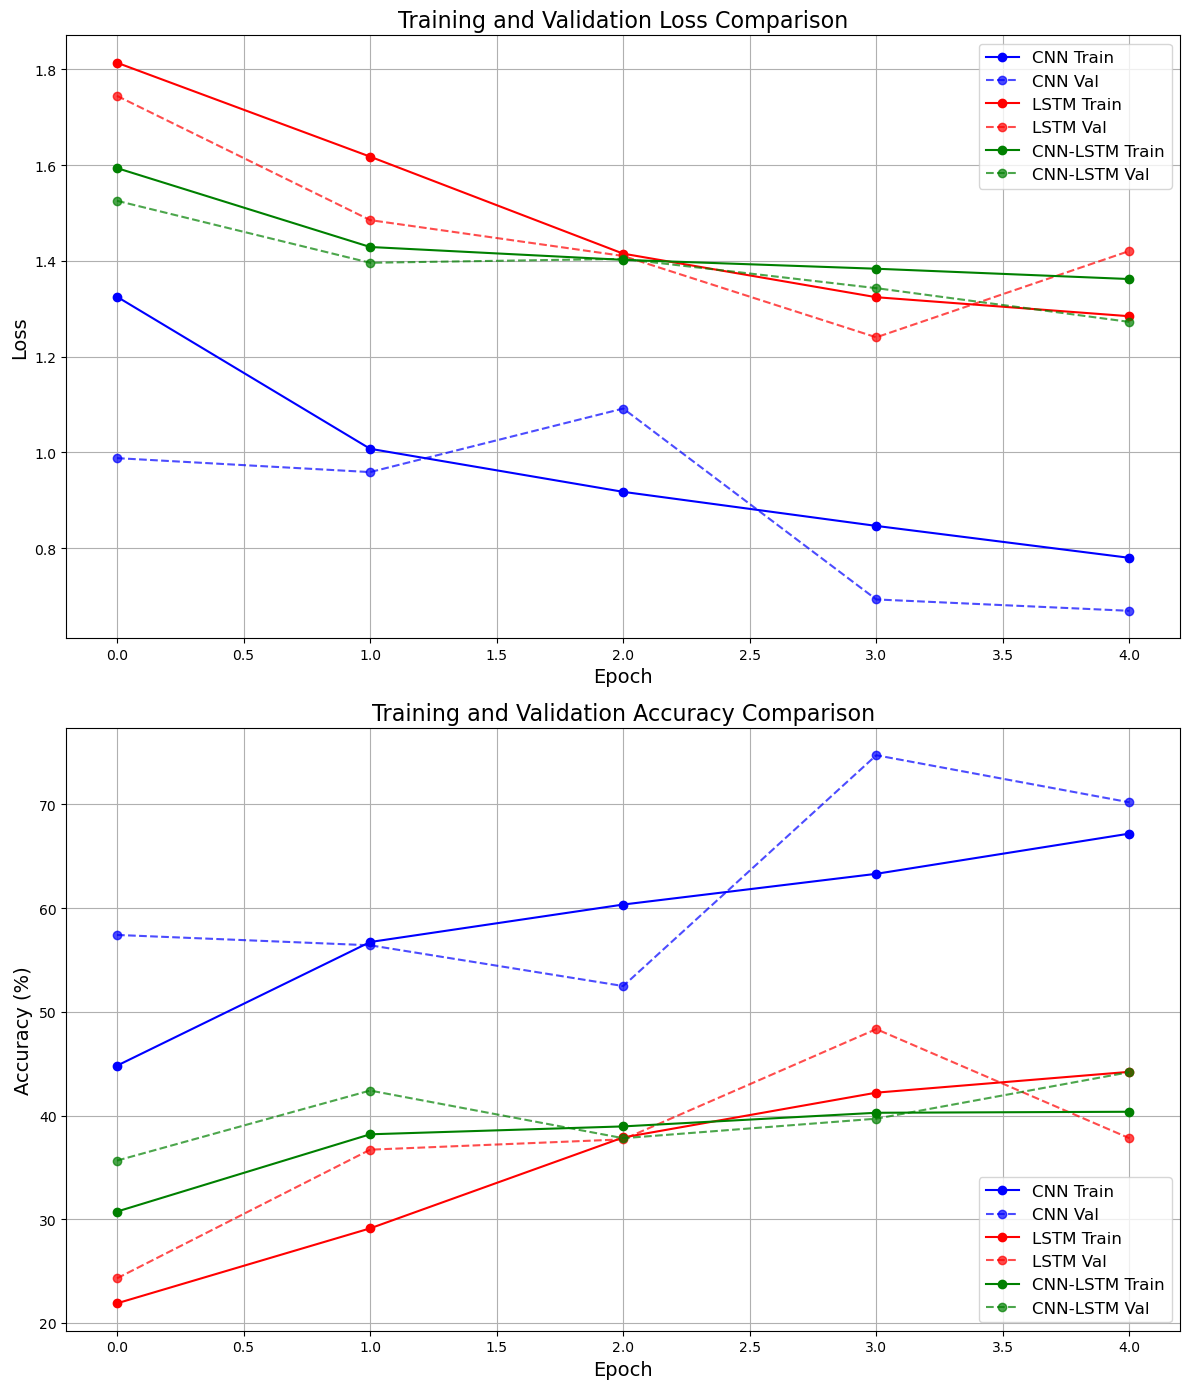

In [18]:
# Plot comparison of all models
print_color("\nPlotting model comparison...", "blue")
plot_model_comparison(all_metrics)
